# Attributions for Siamese Encoders - Demo

In [23]:
import torch
from xsbert import utils
from xsbert.models import XSMPNet, XSRoberta, load_model

### loading exact model

You can load one of the models with exact attribution ability that we provide with the `load_model()` method as follows.
Downloading the checkpoint the first time will take a while. It is then stored in the directory specified by `model_dir`.

In [24]:
model_name = 'mpnet_cos'
model = load_model(model_name, model_dir='../xs_models/')
model.to(torch.device('cuda'))

initializing


XSMPNet(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

If you have already downloaded a checkpoint or want to load one that you created yourself, you can alternatively load it direcly using the respective model classes.

In [3]:
# model_path = '../xs_models/xs_mpnet/'
# model = XSMPNet(model_path)
# model_path = '../xsmodels/xs_distilroberta/'
# model = XSRoberta(model_path)
# model.to(torch.device('cuda:0'))

### initializing attributions

The `init_attribution_to_layer()` method of the `models.XSTransformer` class initializes attributions to the layer with index `idx`. `N_steps` is the number of approximation steps to calculate the *integrated Jacobians* ($N$ in the paper).

`reset_attribution()` removes all hooks that are registered on the model for calculating attributions. After calling it, you can initialize attributions to a different layer.

In [25]:
model.reset_attribution()
model.init_attribution_to_layer(idx=10, N_steps=50)

### computing attributions

In this demo we compute the attribution matrix for a single pair of texts that you can define here:

In [26]:
texta = 'The coffee is bad.'
textb = 'This is not a good coffee.'

After initializing attributions (above), we use the method `attribute_prediction` in the `models.XSTransformer` class to compute the attribution matrix $A$.

When setting the argument `compute_lhs` the method explicitly computes the four terms in the ansatz (left-hand-side of Equation 2 in the EMNLP paper), $f(a, b) - f(r, a) - f(r, b) + f(r, r)$. Below they are named as `score`, `ra`, `rb`, and `rr` in the respective order.

In [14]:
A, tokens_a, tokens_b, score, ra, rb, rr = model.explain_similarity(
    texta, 
    textb, 
    move_to_cpu=False,
    # When using a model trained with a dot product objective you must change sim_measure to "dot".
    sim_measure='cos',
    return_lhs_terms=True
)

100%|██████████| 768/768 [00:02<00:00, 299.16it/s]


### attribution accuracy

The first term, $f(a, b)$ (`score`), is the actual model prediction.
Due to the embedding shift implemented in the `models.ShiftingReferenceTransformer` (cf. Section 2.2 in the EMNLP paper), by construction, the three terms including a reference $r$ must vanish. Below, we explicitly check that this is the case.

We can also calculate how accurate our attributions are by taking the absolute difference between their sum and the model (as described in Section 3.2 of the paper): $\text{error} = \|f(a, b) - \sum_{ij} A_{ij}\|$.

You can change the number of approximation steps $N$ in the `init_attribution_to_layer()` method to see how this attribution error changes.
Generally, attributions to shallower layers require larger $N$ (cf. Section 3.2 in the paper).

In [15]:
tot_attr = A.sum().item()
attr_err = torch.abs(A.sum() - score).item()
print('model prediction: ', score)
print('total attribution: ', tot_attr)
print('reference terms: ', ra, rb, rr)
print('attribution error: ', attr_err)

model prediction:  0.7807894349098206
total attribution:  0.783688485622406
reference terms:  0.0 0.0 0.0
attribution error:  0.0028990507125854492


### plotting attributions

Finally, we can plot the token-token attribution matrix.

C:\Users\Adon\AppData\Local\Temp\ipykernel_21968\3334287601.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


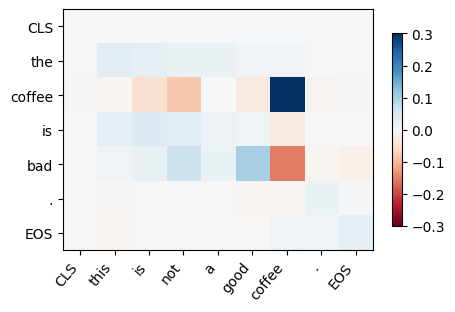

In [16]:
f = utils.plot_attributions(
    A, 
    tokens_a, 
    tokens_b, 
    size=(5, 5),
    range=.3,
    show_colorbar=True, 
    shrink_colorbar=.5
)
f.show()